In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Includes

In [ ]:
! pip install git+https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import time 
import pandas as pd
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals
#import tensorflow as tf
import os
import matplotlib.pyplot as plt
from io import BytesIO
from functools import partial    
import scipy.io as sio 
import time  
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-8vrste_9
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-8vrste_9
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=31432 sha256=702cdf199e0d30c8d8d209855cddf889a811c7795d4b5ae65abed613c3cae162
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5qlhdlf/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip 'Dataset.zip'

# Data preprocessor

In [ ]:
def Normalize(train_data, eps=1e-12):
    """Standard Normalization of data"""
    return (train_data - train_data.mean(0, keepdims=True))/torch.sqrt(train_data.var(0, keepdims=True)+eps)

def NoRmalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [ ]:
def load_data(w, test_names):
    """Load data from .mat file"""
    data = sio.loadmat('wenting_data.mat')
    train_x = (data['Y'][:, w] @ data['training_dV'][w, :]).imag.T
    Nx = data['training_dV'].shape[0] # Number of buses
    Nfault = data['training_dV'].shape[1] # Number of faults
    Ny = max(max(data['training_y_num'])) + 1 # Number of fault locations + 1
    train_y = np.zeros((Nfault, Ny+1))
    for i in range(Nfault):
        train_y[i, data['training_y_num'][0][i] ] = 1
    A = data['A']
    A = NoRmalize(A + np.eye(A.shape[0]))
    k = 0
    for name in test_names:
        test_x = (data['Y'][:, w] @ data[name+'_dV'][w, :]).imag.T
        Nfault = data[name+'_dV'].shape[1] # Number of faults
        test_y = np.zeros((Nfault, Ny))
        for i in range(Nfault):
            test_y[i, data[name+'_y_num'][0][i]] = 1
        test_x = torch.FloatTensor(test_x.reshape([test_x.shape[0], 1, Nx]))
        test_y = torch.LongTensor(test_y)
        if k==0:
            Test_x = test_x.clone()
            Test_y = test_y.clone()
        else:
            Test_x = torch.cat((Test_x, test_x), dim=0)
            Test_y = torch.cat((Test_y, test_y), dim=0)
        k+=1
    train_x = torch.FloatTensor(train_x.reshape([train_x.shape[0], 1, Nx]))
    A = torch.FloatTensor(A)
    train_y = torch.LongTensor(train_y)
    return train_x, train_y, Test_x, Test_y, A, Nx, Ny

#DATA

In [ ]:
# Creation of TRAIN and TEST datasets
n_classes = 87 
buses = 68
coef = 0.9
a = arange(68)
np.random.shuffle(a)
w=[i for i in sorted(a[:int((1-coef)*67)])];
TRAIN = []
TEST = []
trainName ='Datasets/Training/Line_faults_train'
for j in range(4):
  fault_type = j # you can choose from 0 - 3: 
                                          #0 is three phase short circuit; 
                                          #1 is line to ground (LG); 
                                          #2 is double line to ground (DLG); 
                                          #3 is line to line (LL) faults.
  if (j == 0):
    k = [0, 1]
  else:
    k = [1,2,3,4,5]
  for p in k:
    impe_type = p# If you choose fault_type from 1 to 3, the impe_type is in the range of 1 to 5, representing different impedance; 
                # If you choose fault_type = 0, the impe-type is 1 to 2, representing different initial conditions;   
    testName = 'Datasets/Testing/Line_faults_test' +'_type_' + str(fault_type) + '_'+str(impe_type) 
    rootPath = ''# change to where the dataset is located

    DATA = load_all_data(w) 
    TRAIN.append(DATA[0])
    TEST.append(DATA[1])

In [ ]:
#Data for the training and testing
length = 0
for i in range(len(TEST)):
  length += TEST[i][0].shape[0]
Test_labels = np.zeros((length, 87))
train_data = TRAIN[0][0]
Train_labels = TRAIN[0][1]
test_data = TEST[0][0]
A = TRAIN[0][2]
for i in range(len(TEST)-1):
    test_data = np.concatenate((test_data, TEST[i+1][0]))
k = 0
for i in range(len(TEST)):
    Test_labels[k:k+TEST[i][1].shape[0]] =  TEST[i][1]
    k+=TEST[i][1].shape[0]

A = torch.FloatTensor(NoRmalize(abs(A).toarray() + np.eye(A.shape[0])))
X_train = torch.FloatTensor(train_data).permute(0,2,1)
X_test = torch.FloatTensor(test_data).permute(0,2,1)
y_train = torch.LongTensor(Train_labels)
y_test = torch.LongTensor(Test_labels)

# Models

## Linear Regression

In [ ]:
class LR(nn.Module):
    def __init__(self, nin, nout):
        super(LR, self).__init__()
        self.LR = nn.Linear(nin, nout)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LR(x)
        return x

## FeedForward NN

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, nin, nhid, nout):
        super(FeedForward, self).__init__()
        self.NN = nn.Sequential(nn.Linear(nin, nhid), nn.ReLU(), nn.Linear(nhid, nout))
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.NN(x)
        return x

## AlexNet

Here we construct exactly the same model as was used in https://arxiv.org/abs/1810.05247

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, outdim):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(4, 8, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(8, 8, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(8, 8, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(16, outdim),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

## GraphConvNN

Ref: https://arxiv.org/abs/1609.02907

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.adj = adj.to(device)
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        support = torch.einsum('zx,iyx->izy', (self.adj, input))
        output = torch.einsum('xz,izy->ixy', (self.weight, support))
        output = output.permute(0, 2, 1)
        return output
        
class GCNN(nn.Module):
    def __init__(self, nin, nhid, nout, adj, dropout):
        super(GCNN, self).__init__()

        self.gc1 = GraphConvolution(nin, nhid, adj)
        self.classifier = nn.Sequential(
            nn.Linear(nhid, nout),
        )
        self.dropout = dropout
    def forward(self, x):
        x = F.relu(self.gc1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## ODE NN

In [ ]:
class GCDEFunc(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, adj, type):#, dropout:float):
        """Standard GCDN ODE function class. To be passed to an ODEBlock"""
        super().__init__()
        if type == 'Graph':
          self.l = GraphConvolution(input_dim, hidden_dim, adj)
        if type == 'Linear':
          self.l = nn.Linear(input_dim, hidden_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x = F.relu(self.l(x))
        return x

In [ ]:
import torch
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
        out = torch.flatten(out[-1], 1)
        return out
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

# Train Funcs and Supp Funcs

In [ ]:
def train(net, X_train, y_train, X_test, y_test, batch_shape, lr=1.0e-3, optim = 'Adam', Epoch = 50):
    """Train function for all models"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    if optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    batch_size = batch_shape

    test_accuracy_history = []
    test_loss_history = []
    Time = 0

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch.argmax(dim=1))
            loss_value.backward()

            optimizer.step()

        net.eval()
        t0 = time.time()
        test_preds = net.forward(X_test)
        t1 = time.time()
        Time += t1-t0
        test_loss_history.append(loss(test_preds, y_test.argmax(dim=1)).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test.argmax(dim=1)).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
    del net
    return test_accuracy_history, test_loss_history, Time/Epoch

In [ ]:
from matplotlib.pyplot import figure
def acc_loss_graph(accuracies, losses, net_list, observ, Noise, save_file_name='plot.png', download=False):
    """Plot function for graphs of accuracies"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(6)
    fig.set_figwidth(8)
    fig.suptitle('Observ = '+str(observ)+ '$\%$, Noise = ' + str(Noise)+'$\%$')
    fig.subplots_adjust(bottom=0.5)
    
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    ax1.legend()
    ax1.grid()
    ax1.set_title(' ')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Accuracy')
    fig.tight_layout()

    for experiment_id in net_list:

        ax2.plot(losses[experiment_id], label=experiment_id)
    ax2.legend()
    ax2.grid()
    ax2.set_title(' ');
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss, LogLoss')
    fig.tight_layout()

# Main

In [ ]:
n_classes = 87 
buses = 68
coef = 0.95
a = arange(68)
ACC = []
LOSS = []
TIME = []
Buses = []
for i in range(500):
    print(i)
    np.random.shuffle(a)
    w=[i for i in sorted(a[:int((1-coef)*67)])];
    Buses.append(w)
    X_train, y_train, X_test, y_test, A, _, _ = load_data(w, ['testing0', 'testing1', 'testing2', 'testing3'])
    
    losses = {}
    accuracy = {}
    Time = {}

    LinReg = LR(buses, n_classes)
    accuracy['LR'], losses['LR'], Time['LR'] = train(LinReg, X_train, y_train, X_test , y_test, 100, lr=0.001, Epoch=1000)
    print ('Trainning of LR is DONE', accuracy['LR'][-1])

    ACC.append(accuracy)

In [ ]:
 FFNN = FeedForward(buses, 32, n_classes)
    accuracy['FFNN'], losses['FFNN'], Time['FFNN'] = train(FFNN, X_train, y_train, X_test , y_test, 100, lr=0.001, Epoch=1000)
    print ('Trainning of FFNN is DONE', accuracy['FFNN'][-1])

    CNN = AlexNet(n_classes)
    accuracy['Alexnet'], losses['Alexnet'], Time['Alexnet'] = train(CNN, X_train , y_train, X_test, y_test, 100, lr=0.001, Epoch=1000)
    print ('Trainning of AlexNet is DONE', accuracy['Alexnet'][-1])

    graph_NN = GCNN(buses, 32, n_classes, A, 0.0)
    accuracy['GCNN'], losses['GCNN'], Time['GCNN'] = train(graph_NN, X_train, y_train, X_test , y_test, 100, lr=0.001, Epoch=1000)
    print ('Trainning of GCNN is DONE', accuracy['GCNN'][-1])

    gdefunc = GCDEFunc(input_dim=buses, hidden_dim=buses, adj=A, type='Linear')
    gde = ODEBlock(odefunc=gdefunc)
    LinODE = nn.Sequential(gde, nn.Linear(buses, n_classes))
    accuracy['ODE_Lin'], losses['ODE_Lin'], Time['ODE_Lin'] = train(LinODE, X_train, y_train, X_test, y_test, 100, 0.001, Epoch=1000)
    print ('Trainning of ODE_Lin NN is DONE', accuracy['ODE_Lin'][-1])

    gdefunc = GCDEFunc(input_dim=buses, hidden_dim=buses, adj=A, type='Graph')
    gde = ODEBlock(odefunc=gdefunc)
    GraphODE = nn.Sequential(gde, nn.Linear(buses, n_classes))
    accuracy['ODE_Graph'], losses['ODE_Graph'], Time['ODE_Graph'] = train(GraphODE, X_train, y_train, X_test, y_test, 100, 0.001, Epoch=1000)
    print ('Trainning of ODE_Graph NN is DONE', accuracy['ODE_Graph'][-1])

In [ ]:
def stack(Arr, name):
    out = torch.FloatTensor(Arr[0][name]).reshape(1,-1)
    for i in range(1, len(Arr)):
      out = torch.cat((out, torch.FloatTensor(Arr[i][name]).reshape(1,-1)), dim=0)
    return out

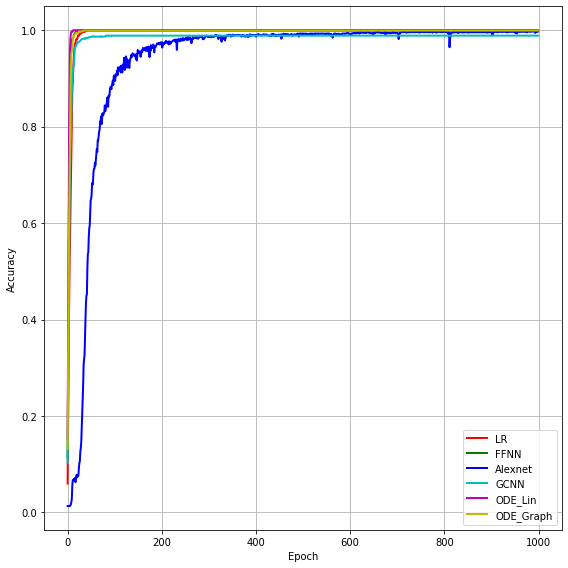

In [ ]:
Model_list = ['LR', 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph']
Color_list = ['r', 'g', 'b', 'c', 'm', 'y']
plt.figure(figsize=(8,8))
plt.grid()
for model_name, color in zip(Model_list, Color_list):
    M = stack(ACC, model_name).mean(0)
    D = stack(ACC, model_name).std(0)
    plt.plot(torch.arange(len(M)), M, color , lw = 2, zorder = 9, label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

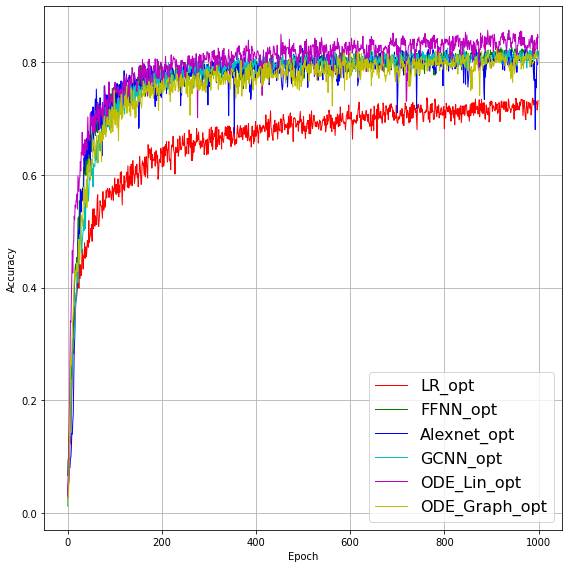

In [ ]:
Model_list = ['LR', 'FFNN', 'Alexnet', 'GCNN', 'ODE_Lin', 'ODE_Graph']
Color_list = ['r', 'g', 'b', 'c', 'm', 'y']
plt.figure(figsize=(8,8))
plt.grid()
for model_name, color in zip(Model_list, Color_list):
    plt.plot(accuracy[model_name], color , lw = 1, zorder = 9, label=model_name+'_opt')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
plt.legend(loc="lower right", prop={'size': 16})
plt.tight_layout()
plt.show()

In [ ]:
n_classes = 87 
buses = 68
coef = 0.0
a = arange(68)
np.random.shuffle(a)
w=[i for i in sorted(a[:int((1-coef)*67)])];
X_train, y_train, X_test, y_test, A, _, _ = load_data(w, ['testing0', 'testing1', 'testing2', 'testing3']) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.


In [ ]:
losses = {}
accuracy = {}
Time = {}
LinReg = LR(buses, n_classes)
accuracy['LR'], losses['LR'], Time['LR'] = train(LinReg, X_train, y_train, X_test , y_test, 200, lr=0.001, Epoch=2000)
print ('Trainning of LR is DONE')

FFNN = FeedForward(buses, 32, n_classes)
accuracy['FFNN'], losses['FFNN'], Time['FFNN'] = train(FFNN, X_train, y_train, X_test , y_test, 200, lr=0.001, Epoch=2000)
print ('Trainning of FFNN is DONE')

CNN = AlexNet(n_classes)
accuracy['Alexnet'], losses['Alexnet'], Time['Alexnet'] = train(CNN, X_train , y_train, X_test, y_test, 100, lr=0.001, Epoch=1000)
print ('Trainning of AlexNet is DONE')

In [ ]:
gdefunc = GCDEFunc(input_dim=buses, hidden_dim=buses, adj=A, type='Linear')
gde = ODEBlock(odefunc=gdefunc)
LinODE = nn.Sequential(gde, nn.Linear(buses, n_classes))
accuracy['ODE_Lin'], losses['ODE_Lin'], Time['ODE_Lin'] = train(LinODE, X_train, y_train, X_test, y_test, 100, 0.001, Epoch=500)
print ('Trainning of ODE_Lin NN is DONE')

In [ ]:
gdefunc = GCDEFunc(input_dim=buses, hidden_dim=buses, adj=A, type='Graph')
gde = ODEBlock(odefunc=gdefunc)
GraphODE = nn.Sequential(gde, nn.Linear(buses, n_classes))
accuracy['ODE_Graph'], losses['ODE_Graph'], Time['ODE_Graph'] = train(GraphODE, X_train, y_train, X_test, y_test, 100, 0.001, Epoch=500)
print ('Trainning of ODE_Graph NN is DONE')

In [ ]:
graph_NN = GCNN(buses, 32, n_classes, A, 0.0)
accuracy['GCNN'], losses['GCNN'], Time['GCNN'] = train(graph_NN, X_train, y_train, X_test , y_test, 200, lr=0.001, Epoch=2000)
print ('Trainning of GCNN is DONE')

In [ ]:
! pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

In [ ]:
print(summary(LinReg, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1             [1, 87]           6,003           6,003
Total params: 6,003
Trainable params: 6,003
Non-trainable params: 0
-----------------------------------------------------------------------


========================== Hierarchical Summary ==========================

LR(
  (LR): Linear(in_features=68, out_features=87, bias=True), 6,003 params
), 6,003 params





In [ ]:
print(summary(FFNN, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1             [1, 32]           2,208           2,208
            ReLU-2             [1, 32]               0               0
          Linear-3             [1, 87]           2,871           2,871
Total params: 5,079
Trainable params: 5,079
Non-trainable params: 0
-----------------------------------------------------------------------


========================== Hierarchical Summary ==========================

FeedForward(
  (NN): Sequential(
    (0): Linear(in_features=68, out_features=32, bias=True), 2,208 params
    (1): ReLU(), 0 params
    (2): Linear(in_features=32, out_features=87, bias=True), 2,871 params
  ), 5,079 params
), 5,079 params





In [ ]:
print(summary(LinODE, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
        ODEBlock-1             [1, 68]           4,692           4,692
          Linear-2             [1, 87]           6,003           6,003
Total params: 10,695
Trainable params: 10,695
Non-trainable params: 0
-----------------------------------------------------------------------


=========================== Hierarchical Summary ===========================

Sequential(
  (0): ODEBlock(
    (odefunc): GCDEFunc(
      (l): Linear(in_features=68, out_features=68, bias=True), 4,692 params
    ), 4,692 params
  ), 4,692 params
  (1): Linear(in_features=68, out_features=87, bias=True), 6,003 params
), 10,695 params





In [ ]:
print(summary(GraphODE, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
        ODEBlock-1             [1, 68]           4,692           4,692
          Linear-2             [1, 87]           6,003           6,003
Total params: 10,695
Trainable params: 10,695
Non-trainable params: 0
-----------------------------------------------------------------------


========================= Hierarchical Summary =========================

Sequential(
  (0): ODEBlock(
    (odefunc): GCDEFunc(
      (l): GraphConvolution(), 4,692 params
    ), 4,692 params
  ), 4,692 params
  (1): Linear(in_features=68, out_features=87, bias=True), 6,003 params
), 10,695 params





In [ ]:
print(summary(graph_NN, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
   GraphConvolution-1          [1, 1, 32]           2,208           2,208
             Linear-2             [1, 87]           2,871           2,871
Total params: 5,079
Trainable params: 5,079
Non-trainable params: 0
--------------------------------------------------------------------------


========================== Hierarchical Summary ==========================

GCNN(
  (gc1): GraphConvolution(), 2,208 params
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=87, bias=True), 2,871 params
  ), 2,871 params
), 5,079 params





In [ ]:
print(summary(CNN, torch.zeros((1, 1, X_train.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv1d-1          [1, 4, 64]              24              24
            ReLU-2          [1, 4, 64]               0               0
       MaxPool1d-3          [1, 4, 32]               0               0
          Conv1d-4          [1, 8, 28]             168             168
            ReLU-5          [1, 8, 28]               0               0
       MaxPool1d-6          [1, 8, 14]               0               0
          Conv1d-7          [1, 8, 12]             200             200
            ReLU-8          [1, 8, 12]               0               0
       MaxPool1d-9           [1, 8, 6]               0               0
         Conv1d-10           [1, 8, 4]             200             200
           ReLU-11           [1, 8, 4]               0               0
      MaxPool1d-12           [1, 8, 2]               0               0
     